In [65]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax as dfx
import optax
import matplotlib.pyplot as plt
import numpy as np

Vector field

In [66]:
class VectorField(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2 = jr.split(key, 2)
        self.layers = [
            eqx.nn.Linear(2, 10, use_bias=True, key=key1),
            jnp.tanh,
            eqx.nn.Linear(10, 1, use_bias=True, key=key2),
        ]

    def __call__(self, t, y, args):
        t = jnp.asarray(t)[None]
        y = jnp.concatenate([t, y])
        for layer in self.layers:
            y = layer(y)
        return y

Neural ODE

In [67]:
class NeuralODE(eqx.Module):
    vector_field: VectorField

    def __init__(self, *, key):
        self.vector_field = VectorField(key)

    def __call__(self, times):
        vf = dfx.ODETerm(self.vector_field)
        t0 = 0
        t1 = 9.99
        dt0 = 0.01
        saveat = dfx.SaveAt(ts=times)
        y0 = jnp.array([0.0])
        solver = dfx.Midpoint()
        sol = dfx.diffeqsolve(
            terms=vf,
            solver=solver,
            t0=t0,
            t1=t1,
            dt0=dt0,
            y0=y0,
            saveat=saveat,
            max_steps=999,
        )
        ts = sol.ts
        ys = sol.ys
        return ts, ys[:, -1]

optimisation helpers

In [68]:
@eqx.filter_value_and_grad
def grad_loss(model, ys_data, times):
    ts, ys = model(times)
    return jnp.mean((ys_data - ys) ** 2)


@eqx.filter_jit
def make_step(model, ys_data, times, optim, opt_state):
    loss, grads = grad_loss(model, ys_data, times)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

PK model

In [69]:
no_noise_data = jnp.load("../data/ODE_solution.npy")

num_runs = 5
num_trajectories = 10

avg_weight = 70
dose = 1
bioavailability = 1
noise_level = 0.05

W_ka, B_ka = 0.3, 0.01 * avg_weight
W_cl, B_cl = 0.3, np.log(0.053 * avg_weight)
W_v, B_v = 0.3, 0.733 * avg_weight
B_clwt = 0.2

covariance_matrix = np.diag([W_ka**2, W_cl**2, W_v**2])
variability_factors = np.random.multivariate_normal(
    [0, 0, 0], covariance_matrix, 1
)[0]

individual_weight = np.random.normal(0, 0, 1)[0]
ka = B_ka * np.exp(variability_factors[0])
cl = np.exp(B_cl + B_clwt * individual_weight + variability_factors[0])
v = B_v * np.exp(variability_factors[0])

denominator = v * ka - cl

t0 = 0
t1 = 10
dt = 0.01
time_points = np.arange(t0, t1, dt)

noisy_solutions = np.full((num_runs, num_trajectories, len(time_points)), np.nan)

for i in range(num_runs):
    for j in range(num_trajectories):
        noise = np.random.normal(0.0, noise_level, len(time_points))

        analytic_solution = (dose * v * bioavailability * ka / denominator) * (
            np.exp(-(cl / v) * time_points) - np.exp(-ka * time_points)
        )
        noisy_solution = analytic_solution * np.exp(noise)

        noisy_solutions[i, j, :] = noisy_solution

sparsity loop

In [70]:
SEED = 1
key = jr.key(SEED)

sparsity_levels = [
    1000,
    501,
    251,
    101,
    51,
    41,
    31,
    21,
    11,
]

# densest set of times
dense_times = jnp.linspace(0, 9.99, 1000)

# generate a key for each run
keys = jr.split(key, num_runs)

# storage
times_all_runs = []
sols_all_runs = []
mse_all_runs = []

for run in range(num_runs):
    print("")
    print(f"Run {run} ...")
    print("")

    # keys
    num_keys = len(sparsity_levels)
    more_keys = jr.split(key, num_keys)

    # storage
    all_times = []
    all_sols = []
    all_mse = []

    # loop over sparsity levels
    for idx, sparsity in enumerate(sparsity_levels):
        print("")
        print(f"Running sparsity level {sparsity} ...")
        print("")
        # split keys
        model_key, perm_key = jr.split(more_keys[idx], 2)
        # get train time indices
        train_time_idxs = jnp.linspace(0, 999, sparsity, dtype=jnp.int32)
        # get corresponding times
        times = dense_times[train_time_idxs]
        # define neural ODE
        neural_ode = NeuralODE(key=model_key)
        # initialise optimiser
        optim = optax.adam(1e-2)
        opt_state = optim.init(eqx.filter(neural_ode, eqx.is_inexact_array))
        # main training loop
        steps = 1000
        perms = jr.randint(perm_key, shape=(steps,), minval=0, maxval=9)
        for step in range(steps):
            ys_data = (noisy_solutions[run, perms[step], :])[train_time_idxs]
            loss, neural_ode, opt_state = make_step(
                neural_ode, ys_data, times, optim, opt_state
            )
            if step % 100 == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}")
        # get prediction from trained model
        ts, ys = neural_ode(dense_times)
        all_times.append(ts)
        all_sols.append(ys)
        # get mse error between prediction and real solution
        err = (ys - no_noise_data)**2
        all_mse.append(jnp.mean(err))

    times_all_runs.append(all_times)
    sols_all_runs.append(all_sols)
    mse_all_runs.append(all_mse)


Run 0 ...


Running sparsity level 1000 ...

Step: 0, Loss: 1.7698992490768433
Step: 100, Loss: 0.008464086800813675
Step: 200, Loss: 0.006005540024489164
Step: 300, Loss: 0.004203019663691521
Step: 400, Loss: 0.0026861783117055893
Step: 500, Loss: 0.0017444210825487971
Step: 600, Loss: 0.0014706305228173733
Step: 700, Loss: 0.0012179107870906591
Step: 800, Loss: 0.0011649205116555095
Step: 900, Loss: 0.0011194691760465503
Step: 999, Loss: 0.0010849864920601249

Running sparsity level 501 ...

Step: 0, Loss: 13.406484603881836
Step: 100, Loss: 0.0050404989160597324
Step: 200, Loss: 0.004100929945707321
Step: 300, Loss: 0.003021544311195612
Step: 400, Loss: 0.002214631997048855
Step: 500, Loss: 0.001730706891976297
Step: 600, Loss: 0.0014630265068262815
Step: 700, Loss: 0.001290130545385182
Step: 800, Loss: 0.0009868944762274623
Step: 900, Loss: 0.0011341690551489592
Step: 999, Loss: 0.0011204502079635859

Running sparsity level 251 ...

Step: 0, Loss: 0.710980236530304
Step: 100, Loss

In [71]:
avg_mse = np.zeros(len(sparsity_levels))
for ii in range(num_runs):
    for jj in range(len(sparsity_levels)):
        avg_mse[jj] += mse_all_runs[ii][jj]
avg_mse = avg_mse/num_runs

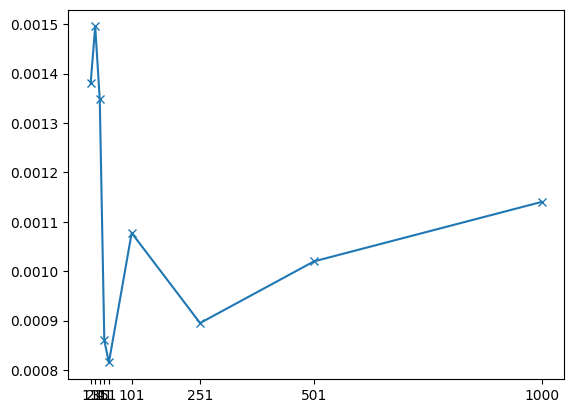

In [79]:
plt.plot(sparsity_levels, avg_mse, marker="x")
plt.xticks(sparsity_levels)
plt.show()

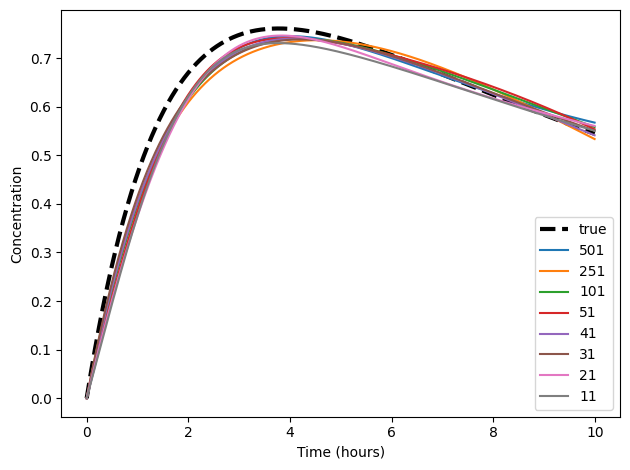

In [96]:
plt.plot(dense_times, no_noise_data, linewidth=3, color="black", linestyle="--", label="true")
for k, level in enumerate(sparsity_levels[1:]):
    plt.plot(dense_times, sols_all_runs[0][k], label=f"{level}")
plt.xlabel("Time (hours)")
plt.ylabel("Concentration")
plt.legend()
plt.tight_layout()
plt.savefig("different_sparsities.png", dpi=600)
plt.show()